In [279]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import os

In [280]:
def take_contur_mask(mask):
    # use sobel filter
    sobelx_vert = cv2.Sobel(mask,cv2.CV_64F,1,0,ksize=1)
    sobelx_horiz = cv2.Sobel(mask,cv2.CV_64F,0,1,ksize=1)
    # connect sobelx_vert and sobelx_horiz
    sobelx = cv2.bitwise_or(sobelx_vert, sobelx_horiz)
    # colour soblex contour on red colour
    for i in range(np.shape(sobelx)[0]):
        for j in range(np.shape(sobelx)[1]):
            if sobelx[i][j] != 0:
                sobelx[i][j] = 255
    
    #add dimension
    # sobelx to image
    sobelx = np.expand_dims(sobelx, axis=2)
    # sobelx to rgb
    sobelx = np.concatenate((sobelx, sobelx, sobelx), axis=2)
    #change soblex white colour to red
    for i in range(np.shape(sobelx)[0]):
        for j in range(np.shape(sobelx)[1]):
            if sobelx[i][j][0] == 255:
                sobelx[i][j][0] = 255
                sobelx[i][j][1] = 0
                sobelx[i][j][2] = 0
   
    

    return sobelx

def blure_pixels(img, mask_img):
    for i in range(np.shape(mask_img)[0]):
        for j in range(np.shape(mask_img)[1]):
            if mask_img[i][j] != 0 :
                img[i][j] = 0
    img = cv2.bilateralFilter(img,9,4000,4000)
    return img

def add_exp(img, mask_img, img_main):
    #put img to greyscale and add dimension
    greyscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    greyscale_img = np.expand_dims(greyscale_img, axis=2)
    for i in range(np.shape(mask_img)[0]):
        for j in range(np.shape(mask_img)[1]):
            if mask_img[i][j] != 0:
                img[i][j] = img_main[i][j]
            else:
                img[i][j] = greyscale_img[i][j]
    
    return img



In [281]:
# put out images together and plot tittle for each image
def save_compare(img_main, protop_out, ace_out, rs_out, klasa, i):
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].imshow(img_main)
    axs[0, 0].set_title('Original')
    axs[0, 1].imshow(protop_out)
    axs[0, 1].set_title('ProtoPNet')
    axs[1, 0].imshow(ace_out)
    axs[1, 0].set_title('ACE')
    axs[1, 1].imshow(rs_out)
    axs[1, 1].set_title('RISE')
    # remove x and y axis
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])

    plt.show()
    #save result
    fig.savefig(f'result{klasa}_{i}.png')
    



In [282]:
#rgm to hsv
# protop_img_hsv = cv2.cvtColor(protop_img, cv2.COLOR_RGB2)
# plt.imshow(protop_img_hsv)
# Convert BGR to HSV
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
def protop_flow(protop_img,img_main):
    
    protop_img = protop_img[:,:,:3]
    
    prev_mask = np.zeros((224, 224), dtype=np.uint8)
    for i in range(224):
        for j in range(224):
            if protop_img[i][j][1]  > 50 and protop_img[i][j][0] < 90  and protop_img[i][j][2] >110: #protop_img[i][j][1] <= 165 and protop_img[i][j][0] <= 169:
                prev_mask[i][j] = 255
            else:
                prev_mask[i][j] = 0
    # Threshold the HSV image to get only blue colors
    mask = prev_mask#cv2.inRange(protop_img, lower_blue, upper_blue)
    
    # mask to image
    mask = np.expand_dims(mask, axis=2)
    print(type(prev_mask), type(mask))
    #print shape
    print(np.shape(prev_mask), np.shape(mask))
    #close operation
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    #sort each conturs and schow mask witch every contur
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #sort contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    #show mask with every contur
    for i in range(len(contours)):
        # mask = np.zeros((np.shape(mask)[0], np.shape(mask)[1]), dtype=np.uint8)
        cv2.drawContours(mask, contours, i, (255,255,255), -1)
        
   
       

    # img_main to grayscale
    plt.imshow(mask )
    img = blure_pixels(img_main.copy(), mask)
    protop_out = add_exp(img, mask, img_main)
    
    conturs = take_contur_mask(mask)
    protop_out[conturs == 255] = conturs[conturs == 255]
    return protop_out

def ace_flow(ace_img, img_main):
    ace_mask  = cv2.inRange(ace_img, np.array([117,117,117]), np.array([117,117,117]))
    #reverse mask
    ace_mask = cv2.bitwise_not(ace_mask)
    kernel = np.ones((5,5),np.uint8)
    ace_mask = cv2.morphologyEx(ace_mask, cv2.MORPH_CLOSE, kernel)
    img = blure_pixels(img_main.copy(), ace_mask)
    ace_out = add_exp(img, ace_mask, img_main)
    conturs = take_contur_mask(ace_mask)
    ace_out[conturs == 255] = conturs[conturs == 255]
    return ace_out

def rais_flow(rais_img, img_main):
    treshold = 1
    rs_mask  = cv2.inRange(rais_img,  np.array([treshold, treshold, treshold]),   np.array([treshold+200,treshold+200, treshold+200]))
    rs_mask = cv2.bitwise_not(rs_mask)
    kernel = np.ones((5,5),np.uint8)
    test_mask = cv2.morphologyEx(rs_mask, cv2.MORPH_OPEN, kernel)
    rs_mask = cv2.morphologyEx(test_mask, cv2.MORPH_CLOSE, kernel)
    #if rs_mask detect two objects we need to remove one
    #find conturs
    contours, hierarchy = cv2.findContours(rs_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #if we have more than one contur we need to remove one
    if len(contours) > 1:
        #find biggest contur
        #modify functiondo find second biggest contur
        ci = 0
        max_area = 0
        for i in range(len(contours)):
            area = cv2.contourArea(contours[i])
            if area > max_area:
                max_area = area
                ci = i
                
        #remove contur
        rs_mask = np.zeros_like(rs_mask)
        cv2.drawContours(rs_mask, contours, ci, 255, -1)
    #blure pixels

    
    img = blure_pixels(img_main.copy(), rs_mask)
    rs_out = add_exp(img, rs_mask, img_main)
    #put conturs on rs_out
    conturs = take_contur_mask(rs_mask)
    rs_out[conturs == 255] = conturs[conturs == 255]

    
    rs_out[conturs == 255] = conturs[conturs == 255]
    return rs_out



# MAIN

[[ 58  52  49  46  55  56  48  47  50  50  48  46  44  43  42  39  34  31
   26  31  39  39  44  35  36  38  40  42  31  36  33  29  29  31  35  39
   30  27  23  19  27  34  32  30  31  36  44  47  49  48  42  33  29  23
   30  34  41  49  45  53  55  61  67  71  70  79  85  85  83  90  88  82
   86  89  96 102  94  90  95 113 110 116 115 109 114 115 117 121 116 106
  119 118 119 116 117 113 111 114 120 121 121 115 109 116 121 126 116 126
  148 151 132 122 116 128 132 141 141 136 130 107 112 120 106  95  97 114
  100  91  96  95  84  70  69  63  73  77  54  46  62  69  76  79  92 105
   96  70  68 113  99 105  83  93 105 120 116 112 140 157 154 162 158 151
  154 126 138 145 141 128 125 116 103  94  90  91  83  81  79  80  74  80
   83  86  82  83  66  46  57  48  37  33  30  46  70  80  76  75  71  74
   81  84  82  67  77  80  77  79  79  79  91  69  68  72  80  80  75  76
   75  77  79  69  73  70  61  61]
 [ 50  47  46  45  51  55  56  54  51  50  48  46  46  43  42  39  34  31
   

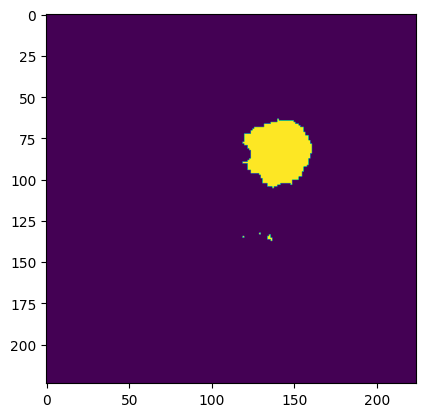

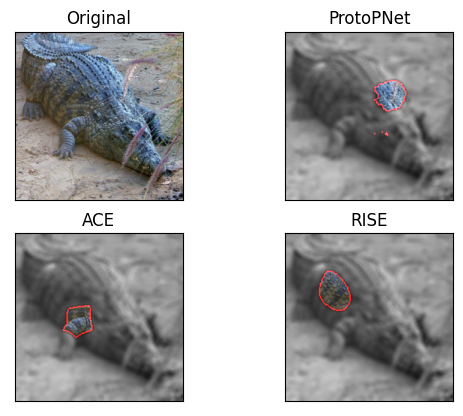

[[ 83  79  82  86  85  86  86  88  86  83  84  87  89  94  98  98 100 101
  100 100  99  97  94  95  95  95  95  95  98  97  96  90  80  51  45  72
   97 108 109 108 111 111 108 109 110 105 100  99 102 102 103 106 105  99
   93  92  93  60  72  60  42  31  23  29  41  27  33  49  55  39  33  35
   47  40  45  44  50  57  60  54  55  41  44  45  49  48  37  41  47  57
   43  25  19  25  31  33  26  24  17  21  24  24  25  35  25  36  37  52
   63  48  35  62  59  59  83  63  84  93  49  41  49  74  96  90 110 100
   98  97  89  93 106 101  92  33  55  87  83  32  21  41  47  43  16  17
   37  32  52  65  28  21  26  17  41  60  32  36  64  32  23  24  25  17
    8   6   6   5   3   3   5   6   7   6   5   7   5   7   6   5   4   5
    6   5   5   6  10  11  10  11  14  19  32  43  37  40  33  38  67  82
   73  68  97 105  78  83  63  29  18  42  58  76  62  38  56  42  36  60
   68  65  70  77  79  82  88  94]
 [ 79  81  86  88  87  89  89  88  81  83  86  91  94  98 102 102 102 103
  1

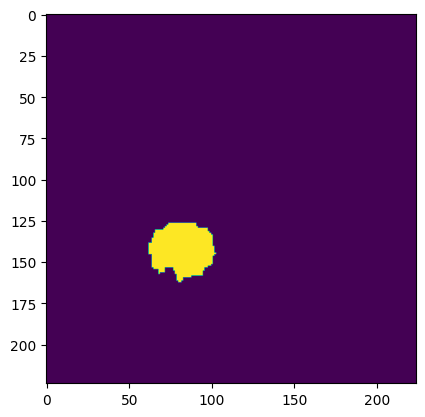

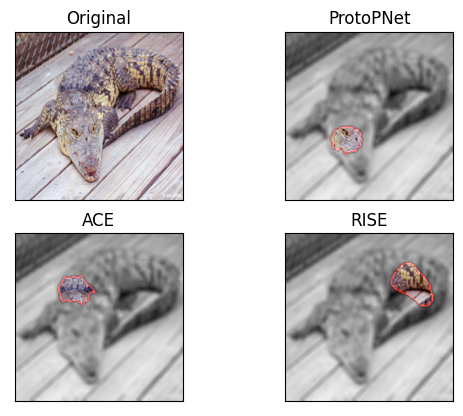

[[ 50  58  51  58  70  75  43  62  51  72  28  19  33  62  81  77  72  83
   94  98 108 104  97  70  77  66  43  64  84  67  43  74  82  58  56  40
   23  32  41  64  72  80  57  37  35  30  29  18  13  35  32  30  11   0
    0   0   0   0   0  11  20  19  16  16  16  17  14  15  16  13  12  17
   19  21  29  45  54  60  61  62  66  66  71  74  70  67  65  79  88  88
   94  98  98  98 101 100 101  98  90  94  98 108 101 105 111 112 123 123
  129 138 147 150 146 140 143 148 148 152 153 160 169 170 168 162 156 142
  132 125 116 104  92  84  79  76  67  67  69  75  78  80  83  82  80  88
   93 100 102 105 104 107 112 121 110 122 135 143 150 162 170 173 174 174
  175 177 178 181 168 160 150 138 134 127 112 106 102  96  97 102 105 104
  104 105 105 107 110 107 110 105  47  26  28  28  28  23  23  32  30  27
   44  49  44  23  27  38  30  21  26  36  54  47  25  42  23  19  19  33
   60  57  34  34  48  37  43  30]
 [ 27  54  47  66  71  57  58  82  68  60  47  39  40  53  76  77  70  90
   

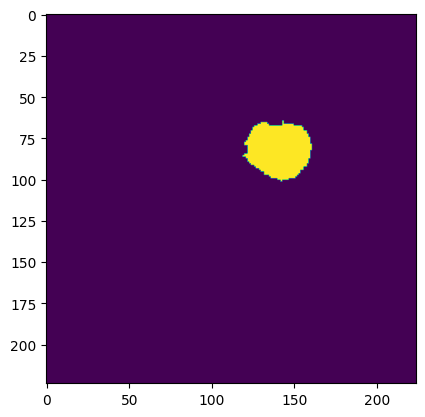

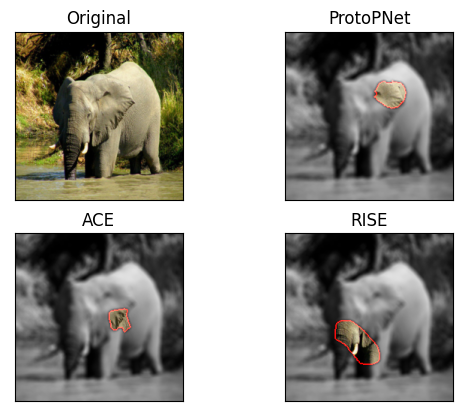

[[ 61  51  52  52  49  41  43  64  41  38  53  52  48  40  35  50  51  56
   59  57  54  63  59  51  60  56  60  78  85  81  84  91  96  93  82  81
   82  87  84  92  90  93  89  97  92  94  98  99  96  95  95  89  87  88
   82  76  76  77  84  86  86  83  80  85  80  84  83  84  84  87  84  79
   84  70  72  91  99 101 102 105 105 106 108 108 111 113 113 111 114 119
  119 120 121 122 125 127 128 127 128 132 130 133 135 138 141 139 140 143
  142 140 138 141 137 124 139 138 138 135 130 126 120 129 138 135 132 134
  131 132 132 137 135 131 128 137 141 138 138 139 135 134 131 126 122 126
  117 118 118 114 108 108 107 101  93  93  89  86  83  79  76  73  70  68
   63  64  65  63  62  61  61  60  61  62  61  62  68  72  73  79  87  91
   92  97 106 108 113 127 130 123 123 125 132 130 123 126 127 135 131 131
  123 112 106  96  94  81  82  68  68  62  54  59  58  62  61  62  59  49
   45  42  49  51  47  56  64  49]
 [ 65  61  54  53  48  42  42  66  60  52  53  51  48  42  41  65  62  64
   

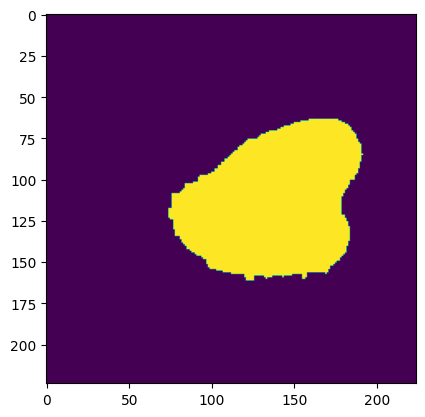

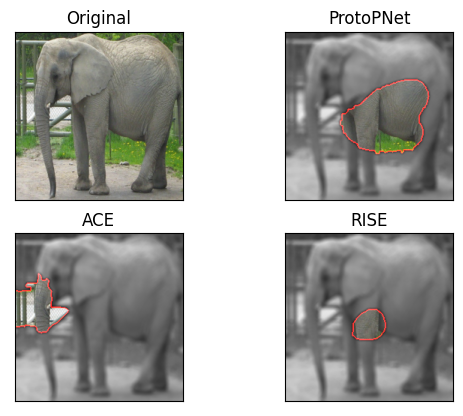

[[  6   7   6   6   7   8  10  12  13  11   9  10  11  14  20  24  27  25
   21  15  10   7   7   7   7   8   7  10  14  12   9   7   6   6   6   6
    6   6   6   6   7   8  15  28  12  37  70  70  70  66  68  68  71  79
   87 104 115 113 107 111 120 128 138 145 146 143 138 136 135 135 134 136
  134 135 136 130 120 115 112 105 104 107 103 102 102 106 108 109 115 109
   99  92  95  96  92 100 113 111 107 105 103 104 102 105 103 105 104 103
  100 100 104 106 109 111 109 107 107 108 106 101  96 100 111 122 123 119
  107  97  97  99  98 100 107 117 121 118 121 125 114 108 107 116 125 137
  145 144 151 141  74  71  75  82  90  93  92  92  92  91  88  86  85  86
   87  85  80  75  68  63  55  47  38  32  24  18  12  10   9  10  11  10
   10  10   8   7   7   8  16  27  34  38  41  43  46  53  57  60  62  62
   61  60  58  55  51  44  36  29  24  22  24  24  24  24  24  28  35  42
   46  45  41  35  30  27  28  28]
 [  5   6   6   5   6   6   8   8   9   9   7   8  10  14  20  24  24  21
   

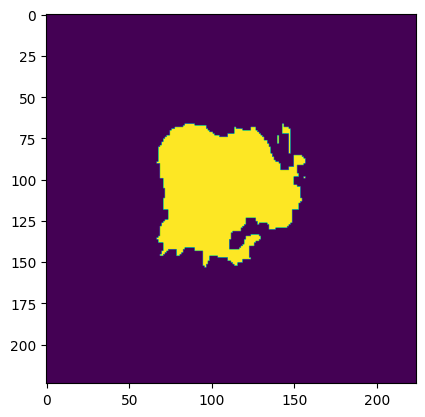

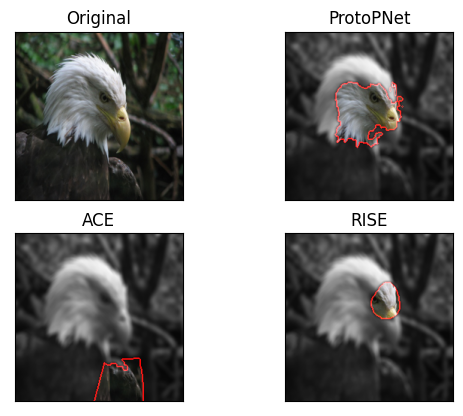

[[ 26  26  28  28  27  26  27  26  25  25  26  26  26  26  25  26  27  27
   28  28  27  26  26  28  27  27  25  25  25  25  25  25  25  24  24  25
   25  25  24  23  24  23  24  24  25  25  26  26  25  28  28  31  37  50
   66  81 109 141 159 144 107 109 107 108 105 100  97  87  69  61  55  49
   45  26   7   5   6   5   7   8  16  15  21  17   8   8  10   8   8   8
    9  10  14  21  27  35  41  48  54  59  66  74  81  86  87  86  87  85
   85  84  84  83  83  85  92  93  98  99  99  95  89  90  90  88  88  91
   93 101  87  86  88  90  90  96  91  92  88  92  96  99 103  99  97  97
   98 100 100 100 100 100  99  98  98 100  96  92  87  84  81  77  73  69
   63  59  58  53  51  49  45  41  37  33  29  24  23  22  23  21  22  21
   21  22  22  22  22  22  22  22  21  23  22  22  22  23  24  25  25  25
   24  23  23  23  25  24  25  23  22  21  22  21  21  21  21  21  20  20
   20  20  21  21  22  22  22  24]
 [ 27  26  28  29  28  28  27  26  26  25  26  27  26  26  27  26  27  27
   

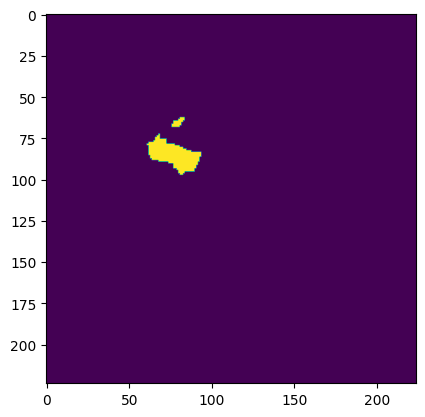

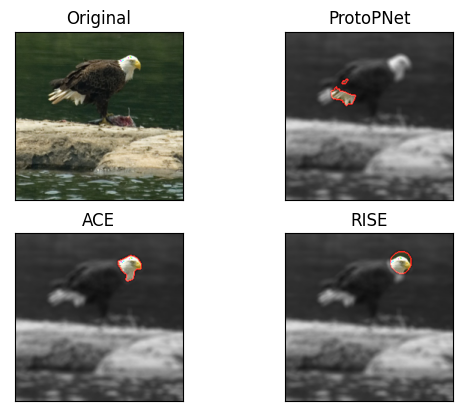

[[ 85  86  86  90  86  85  87  88  86  84  90  81  85  82  88  93  89  87
   87  92  92  89  94  91  89  91  93  97 100  97  94  97  93  97  96 104
  100  97  93  95  94  97  95  87  94  97 102 102  87  98 103 113 118 121
  130 131 142 146 159 165 173 169 174 178 183 188 184 165 163 151 156 151
  151 146 147 139 135 127 124 126 126 115 113 116 115 110 106 107  99  99
  102 100  98 107 101 105 106 114 121 111 110 117 117 120 108 121 119 121
  122 132 128 119 113 121 131 113 121 116 117 111 110 111 111 118 123 121
  123 124 128 129 123 125 121 122 124 135 125 120 119 121 117 121 119 123
  129 137 133 139 139 143 154 168 171 170 159 158 153 141 137 140 132 128
  126 118 117 113 110 103  92  94  99  86  84  87  82  88  93  89  94  90
   93  95  97  99  96  96  99  99  89  81  92  95  96  96  88  93  93  96
   98  94 100  93  93  89  93 100  96  90  93  95  95  89  91  90  90  95
   93  91  95  94  90  90  95  95]
 [ 85  85  81  84  86  85  86  87  84  85  88  88  89  86  88  98  94  83
   

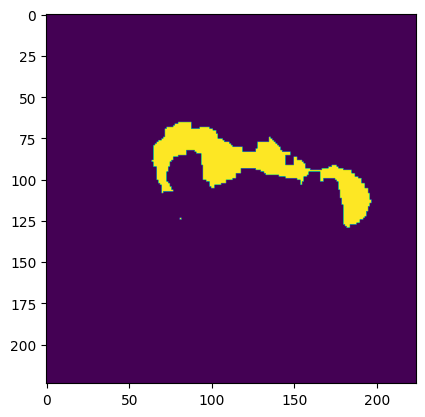

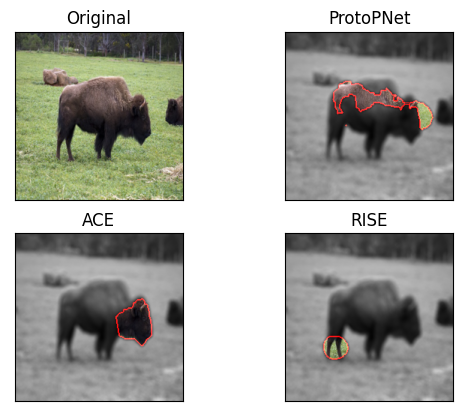

[[ 58  60  59  61  66  69  67  68  70  69  72  72  65  55  50  49  47  43
   38  43  56  50  36  34  36  43  58  68  72  86  97 103 110 114 114 112
  102  86  73  72  79  90  92  91  90  92  94  93  91  88  87  86  86  85
   86  85  85  84  85  87  85  86  89  92  92  91  92  95  95  93  91  92
   89  87  89  90  91  91  89  85  85  91  96  99 101 101  97  92  92  96
   98  99 101 106 105 102  99  96  93  90  91  94  99  99  96  92  87  87
   93 107 114 114 110 107 112 112 108 103  99  96  85  76  72  65  56  51
   45  40  37  37  29  21  22  28  33  33  37  39  35  32  33  35  38  37
   36  39  39  39  45  49  48  47  51  59  69  85 102 121 129 133 131 131
  143 143 153 171 160 145 144 140 129 121 119 110 101 100  99  97  96  99
   99 103 103  96  93  97 100 104 100  99 100  98  98  99  99  98  98 100
   98  97 100 100 101  97 100 102 103 103 103 103 102 100  99  98 101 104
  100  99 101  99 102 101  96  95]
 [ 52  54  59  66  69  67  63  64  67  69  70  64  55  48  46  44  41  35
   

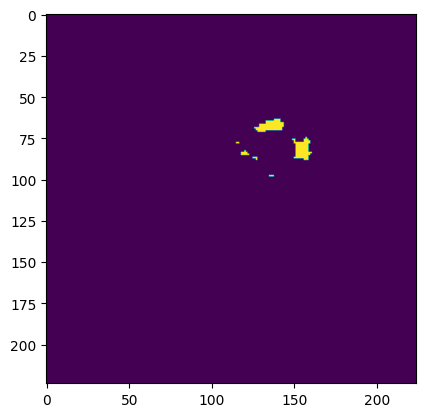

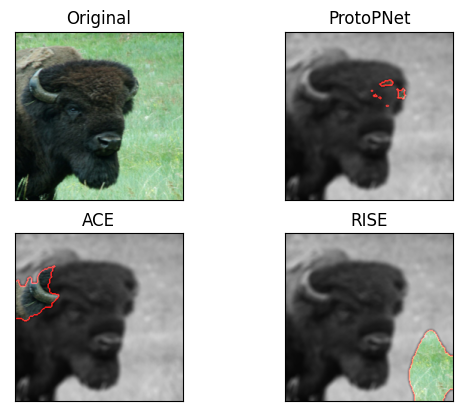

[[126 126 127 127 127 127 127 127 127 127 127 127 127 127 126 126 127 127
  127 127 126 125 119  92  60  45  32  22  16  11  11  16  17  17  13  12
   12  14  13  14  13  11   9   6   9   4   2   1   6  11  15  21  26  35
   49  76 111 150 176 185 191 192 188 186 187 189 190 191 190 185 181 184
  185 182 172 165 161 153 142 134 131 127 123 119 117 115 115 115 115 115
  119 121 121 122 123 126 126 123 123 124 127 127 125 124 130 123 132 129
  128 127 123 124 121 127 114 121 115 116 120 122 117 120 116 110 108 103
  106 104  99 103 100  99  99  99  94  87  77  84  88  91  89  94 100 103
  113 121 125 129 134 147 156 157 154 158 159 157 157 158 159 158 155 157
  155 150 147 145 144 142 138 127 104  59  29  17   9   5  15  29  64  51
   50  45  43  39  34  36  34  33  31  23  16  15  19  18  16  18  14  16
   15  16  17  17  18  17  17  25  30  35  46  51  55  84 100  87  72  74
   92 106 101  37  19  23  25  45]
 [126 126 127 127 127 127 127 126 126 127 127 127 127 127 127 127 127 127
  1

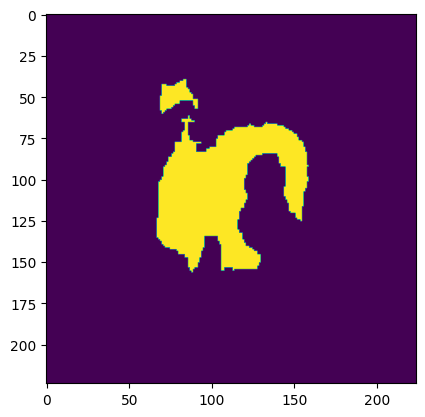

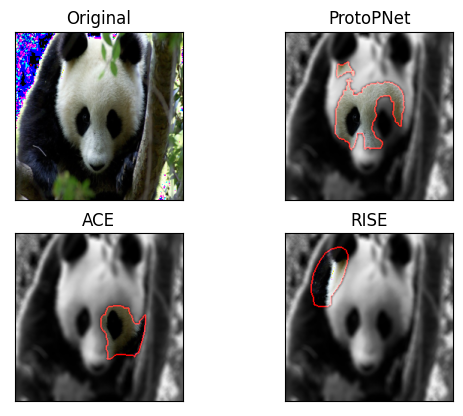

[[ 40  44  45  46  46  45  44  43  41  39  35  32  28  28  27  26  26  26
   26  26  26  26  27  26  27  28  28  28  28  29  30  31  32  31  32  32
   33  33  32  33  32  32  32  33  33  32  32  32  32  32  33  38  43  48
   52  59  88 121 150 166 170 173 175 177 182 188 190 189 187 187 186 186
  185 185 184 183 182 182 182 183 181 180 179 178 175 173 169 163 159 160
  162 165 164 164 167 162 159 163 160 151 145 151 162 154 149 147 143 144
  141 149 145 145 132 138 138 147 148 145 151 135 137 135 133 138 141 127
  122 117 112 109 114 111 117 109 102 105 104  89  55  44  40  40  41  40
   39  38  38  37  37  39  39  38  39  39  40  40  42  42  43  44  47  48
   49  51  52  55  57  60  64  66  70  74  78  80  81  86  97 114 136 155
  165 171 176 176 177 180 179 175 178 180 176 169 163 160 157 149 144 143
  140 133 132 128 120 117 114 111 111 110 110  78  55  54  52  43  52  50
   52  46  39  26  24  21  19  15]
 [ 39  43  45  45  45  45  44  42  40  37  35  31  29  27  27  26  25  25
   

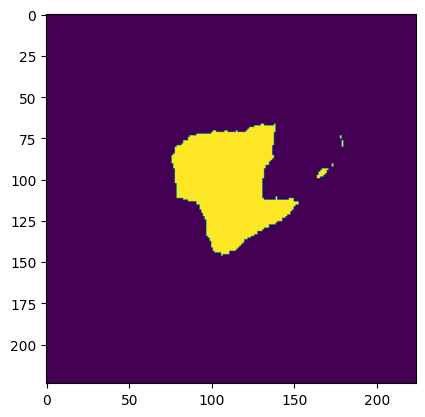

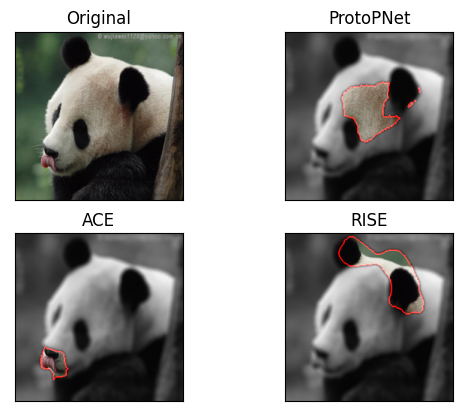

[[ 37  38  39  41  42  42  43  41  40  41  42  43  42  41  42  42  40  39
   39  40  41  43  43  43  46  46  47  48  48  47  42  35  33  32  33  34
   35  37  42  48  51  50  47  43  38  40  42  42  43  43  40  36  35  36
   41  47  49  47  46  44  45  48  48  46  44  39  39  39  39  39  40  43
   44  44  45  46  46  46  44  44  44  44  45  44  43  42  39  41  43  45
   45  45  48  48  46  46  39  38  38  36  36  34  32  35  38  38  37  35
   34  35  39  46  47  47  49  51  50  46  43  40  37  37  35  32  34  38
   36  37  37  38  35  38  41  42  54  52  49  44  36  36  38  37  37  40
   39  38  38  37  39  44  48  48  47  50  46  48  47  47  47  41  40  40
   57  58  53  59  55  48  54  61  56  55  54  48  50  47  45  42  37  39
   44  46  45  47  45  43  44  42  39  38  42  42  40  39  41  43  56  68
   78  83  76  56  48  41  47  51  53  51  43  45  48  54  46  47  55  55
   58  56  53  43  45  39  39  44]
 [ 49  50  51  51  50  50  49  48  45  44  40  39  39  42  45  44  46  45
   

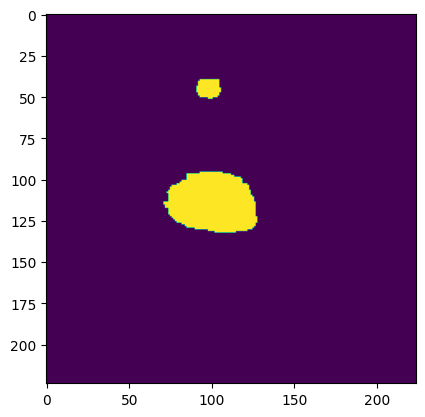

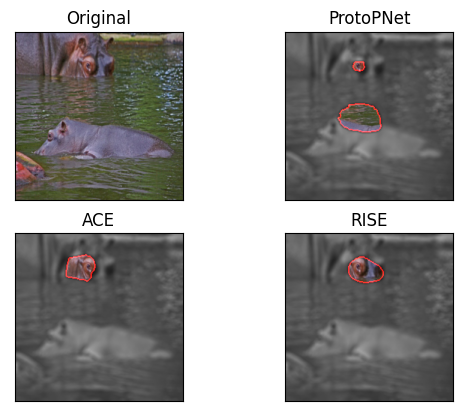

[[ 92  92  93  94  90  89  89  90  91  90  89  92  92  92  90  89  90  93
   94  92  89  90  94  99  98  97 100 100 103 106 107 108 113 113 115 119
  121 122 116 120 122 123 124 128 129 132 132 134 133 136 141 141 140 140
  142 146 146 150 146 146 147 148 149 147 149 151 149 148 147 149 150 154
  154 152 149 145 144 141 140 138 136 133 134 135 135 136 140 141 132 124
  142 157 146 129 127 146 151 142 138 137 138 142 141 129 121 135 141 135
  133 129 129 129 129 130 129 129 133 138 140 143 145 143 142 142 147 154
  151 145 139 133 128 128 125 117 112 105  98  88  84  84  82  72  75  88
   88  87  89  86  92  88  87  78  78  78  75  71  74  77  80  81  82  72
   73  71  72  72  70  72  71  71  77  71  76  76  76  78  75  70  66  71
   69  76  82  75  68  70  69  70  71  70  65  64  63  65  65  72  78  77
   75  75  74  74  71  72  75  74  75  76  74  73  72  70  69  74  81  88
   90  87  87  92  97  97  96  94]
 [ 92  90  90  90  88  88  91  89  90  90  88  88  91  89  88  88  89  93
   

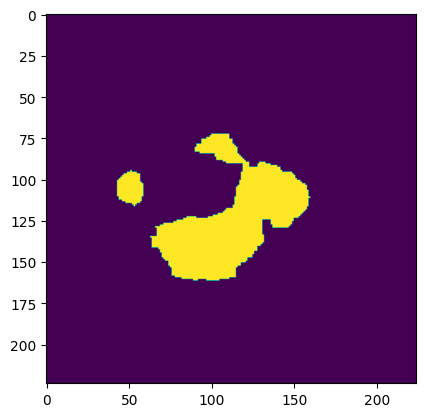

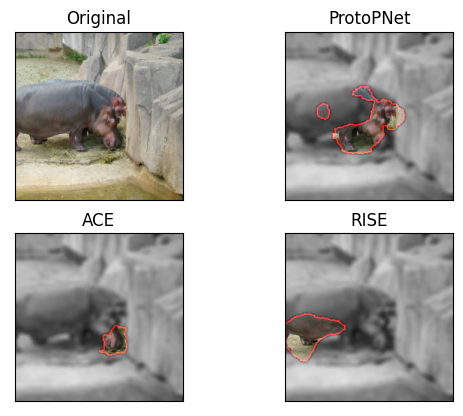

[[127 127 127 127 127 127  68  44  76  68  91  93  80  81  84  89  91  95
   96 109 107 106 114  95  94 103  99 108 102  88  80  79  94 118 109 106
   78 108 102  74 103 119 111  92  82  68  84  85  78  75  69  51  37  26
   17  30  54  61  51  52  54  57  56  60  58  59  71  83  92  90  85  85
  117 152 140 119 132 123 138 112 110 124 129 141 139 137 133 136 136 136
  133 136 135 133 144 148 145 140 143 156 154 129 118 137 139 140 130 122
  111 113 111 106 108 120 133 142 143 149 146 144 143 144 145 138 117 113
  123 118 116 115 111 106  99  90  79  71  68  63  55  47  45  46  44  32
   19  19  22  26  30  35  42  48  58  67  82  82  78  86  92  90  81  79
   83  84  90  81  69  64  60  47  39  31  34  17   1   4  10  20  18  17
   41  90  41  37  62  55  60  54  23  53  62  31  11  13  13   9  16  31
   14  12  22  38  30  15  18  33  10   9   7   4  13   8   7   5   4   1
   24  68 127 127 127 127 127 127]
 [127 127 127 127 127 127  68  52  68  91  98  83  82  95  93  95 100  97
  1

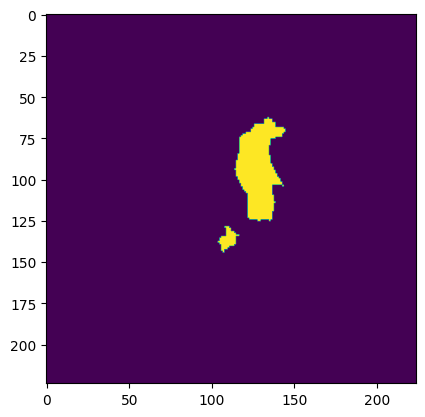

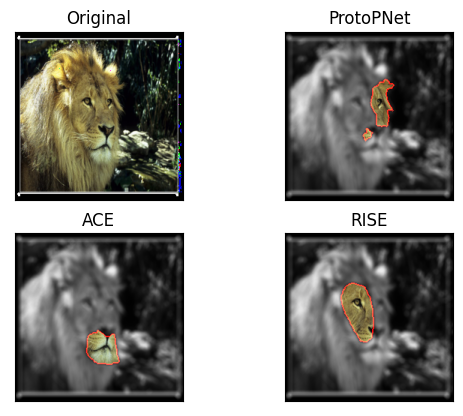

[[ 23  24  24  25  24  28  27  24  20  21  19  20  21  28  37  38  39  35
   33  32  30  28  30  25  25  30  29  30  28  31  30  30  24  21  24  29
   25  23  28  28  34  37  33  33  31  32  35  33  33  31  36  43  57  71
   84  94 104 114 123 130 136 139 146 148 147 146 147 149 148 142 136 135
  142 138 136 134 112  90  89  90  85  91  99 104 103  97  88  85  94  93
   95  96  91  93  98 104 105 109 106 109 112 113 119 120 122 122 121 124
  128 129 127 127 124 120 119 128 130 118 111 109 101 100 100  92  85  85
   89  86  86  92  99  95  95 106 114 118 116 119 123 127 126 129 132 138
  137 131 144 152 155 154 154 153 152 149 150 147 149 146 146 145 147 144
  129 123 121 113 100  87  71  65  61  52  45  45  54  53  57  66  70  78
   79  84  88  89  92  86  73  59  55  53  47  39  34  33  31  28  26  23
   21  21  20  20  21  22  22  21  21  21  22  22  22  21  21  21  21  21
   21  21  21  21  19  21  21  21]
 [ 14  14  16  16  22  27  22  23  24  22  21  24  37  38  38  33  31  33
   

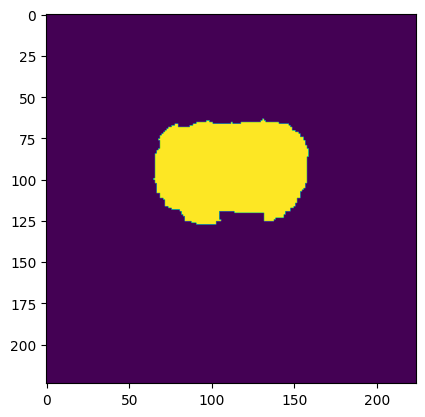

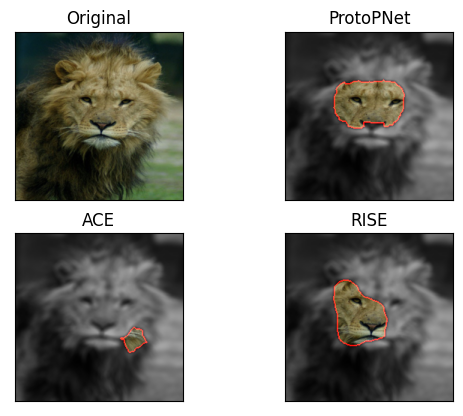

[[ 41  48  45  53  65  60  56  48  41  42  50  46  38  39  41  44  41  38
   43  39  41  49  51  53  62  72  67  46  42  44  48  49  54  53  51  48
   56  70  51  36  49  62  50  39  38  57  51  54  74  73  55  41  45  60
   68  76  79  76  87  90  98 101 106 113 120 117 113 115 114 108 103 101
  106 102 147 177 174 149  99 133 180 145 100 156 165 103 123 124 131 127
  100 151 161 150 109 116 177 189 151 122 139 144 148 137 133 133 114 111
  106 156 145 105 108 111  99  93 102  89  91 106  98  99  99 136 103  81
   83  75  71  66  56  49  47  48  45  44  48  47  46  47  47  48  45  31
   31  45  62  54  53  50  41  44  62  59  46  37  35  46  48  48  55  47
   49  37  35  44  63  86  81  54  68 107 106  84  35  51  96  97  83  93
  120 124 121 110 118 100  98  91  55  46  46  39  40  68  92  82  70  69
   70  57  56  59  69  62  81 102 108 104 109 111 125 127 114  74  69  77
  100 106 116  98  65  67  76 112]
 [ 47  45  49  58  55  48  54  49  41  46  53  46  37  37  35  38  40  39
   

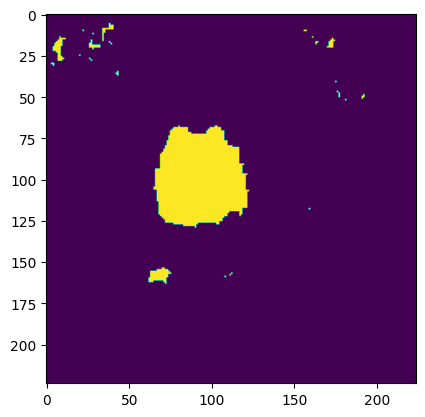

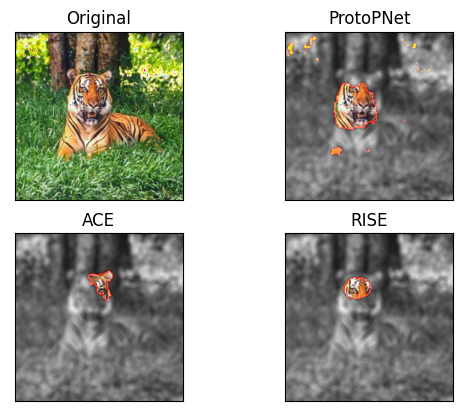

[[ 13   9   8   9  10   9   8   9  10   9   8   6   5   5   5  11  14  13
   16  22  24  30  40  52  57  63  82  93  95  96  94  89  87  89  95  95
   94 103 100 101 103 109 125 119 110 100  86 104 117 120 114 103  89  80
   86 104 105  74  18  11  38  42  23  16  20  41  47  41  63  87  80  45
   51  61  65  75  81  82  94 102 108 119 123 132 138 144 150 156 164 176
  173 167 174 167 143 141 166 147 127 147 127 110 116 122 101  66  48  63
   70  44  28  27  34  48  54  29  23  17  19  16   8   5   5   3   7  18
   16   7  13  26  27  21  19   9   6   6   5   5   5   6   3   3   2   2
    6  13  17  18  21  18  14  10  14  15  14  12   8   9  15  10   4   6
    6   5   6  11  17  22  25  22  11  10  14  17  19  18  17  19  25  24
   23  24  21  14   6   8  11  13  13  13  11   9   9   9  10   8   8   5
    5   6   9  10   8   6   7   7   7   6   5   4   4   3   4   3   4   6
   10  12  18  24  18  11  18  23]
 [ 13  10   9   9   9   8   8   8   9   9   8   6   5   5   6  10  14  13
   

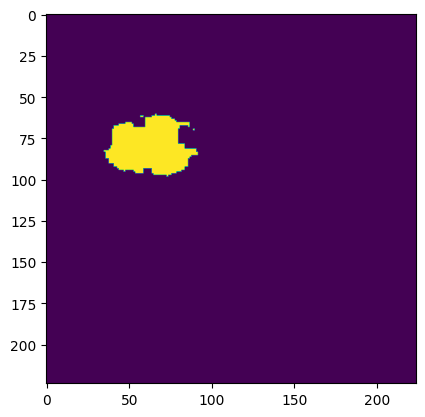

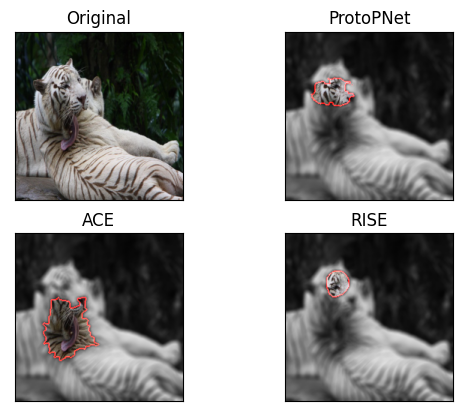

[[ 61  57  58  67  75  81  86  87  87  87  87  87  88  88  88  87  88  87
   85  84  82  79  77  72  68  65  61  58  55  53  52  51  51  51  52  53
   56  59  62  66  69  70  76  80  85  88  94  99 103 108 111 115 120 129
  135 142 146 151 155 158 153 119 105 106 129 135 153 165 148 167 189 176
  179 178 180 171 169 168 167 181 174 169 159 147 147 152 152 158 184 187
  176 156 128 129 154 165 169 162 138 143 142 148 144 142 135 143 165 173
  169 173 175 172 172 172 172 174 176 182 173 164 153 152 163 173 174 176
  181 192 192 182 154 135 169 177 175 180 183 169 164 164 165 164 158 138
  130 132 132 131 129 126 126 121 120 116 114 111 111 109 106 104 104 103
  100  96  92  88  82  78  72  65  61  60  60  61  60  58  57  61  63  62
   60  59  61  63  66  69  69  68  65  66  66  64  61  59  60  60  60  64
   65  66  67  69  72  72  73  75  76  77  77  77  78  80  82  82  82  82
   81  82  82  82  82  79  78  77]
 [ 61  56  58  67  75  82  86  87  87  87  87  88  88  89  89  88  89  88
   

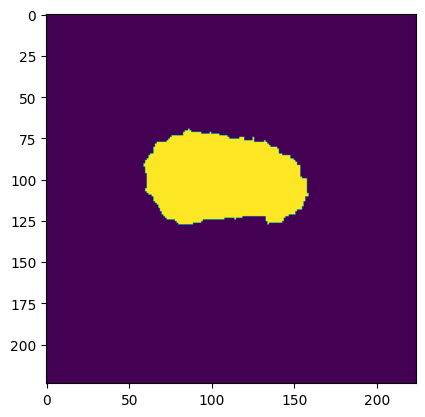

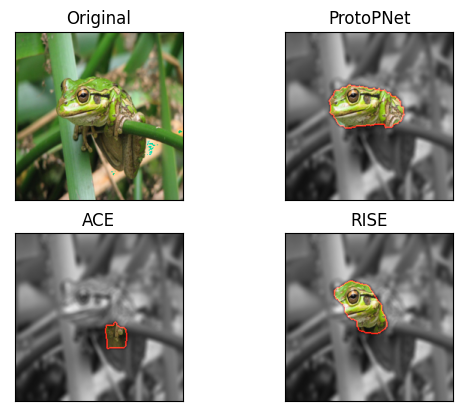

[[ 28  27  25  26  26  28  28  32  34  36  38  41  42  42  41  39  35  33
   29  28  40  74 105 105  83  84  96 106 113 116 115 114 117 115 115 116
  124 133 136 130 128 138 118 105 105 107 109 109 102  90 107 114 113 114
  114 114 113 113 110 109 107  93  95 115 175 170 134 130 155 169 164 162
  161 161 154 141 138 140 143 144 146 147 148 142 129 122 120 122 126 130
  130 138 145 146 155 154 154 143 138 139 137 134 135 132 128 129 133 127
  128 126 126 128 123 126 124 118 118 119 124 124 123 120 126 124 123 121
  119 119 117 117 115 122 120 118 116 124 115 116 113 111 114 117 117 115
  112 109 102 101 104 101  99  97  99  90  82  78  71  68  61  56  51  49
   47  44  33  38  44  30  29  29  30  37  40  30  31  41  54  35  29  28
   24  20  18  20  21  18  16  18  25  34  39  44  53  74 106 116 107  89
   76  71  67  58  46  35  27  25  26  26  27  25  26  26  26  26  26  26
   24  25  25  24  25  25  24  22]
 [ 28  26  25  25  25  27  28  32  34  37  40  43  44  44  43  41  37  36
   

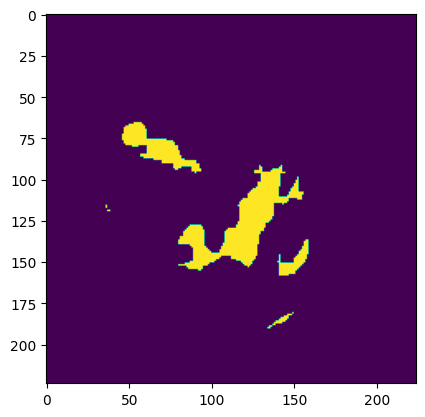

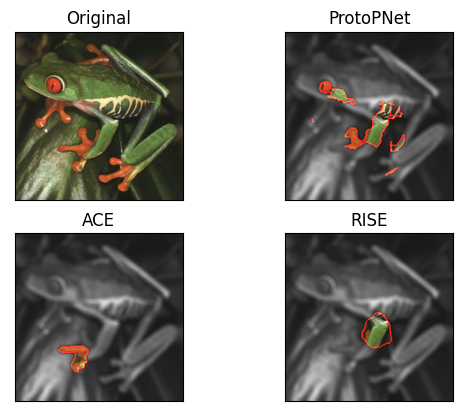

[[ 92  96  93  95  96  92  93  94 101  99  94  95  99 100 101  99  99 100
   99  95  93  92  99  94  95  92  99  93  89  91  94  95  98  98  96  97
   95  91  94  98  97  98  97 100 103  94  86  74  60  51  48  42  40  40
   43  49  61  78  91 111 104 116 129  78 101 140 136 121  97 123 135 128
  134 147 146 131 105 174 193 197 198 143 168 188 124 104 104 118 185 201
  196 192 133  96  96  94  93  93  94 144 192 191 197 199 196 166 116  93
   85  84  84  85  83  82  83  85  85  86  83  84  84  87  85 113 154 161
  163 160 155 154 151 145 140 134 130 129 131 125 116 111 110  98 102 102
   98  91  88  89  87  85  85  85  84  90  92  88  93  88  89  87  80  61
   50  54  66  75  75  71  64  61  72  81  86  83  83  85  83  80  75  73
   71  70  69  67  66  62  62  70  77  88  94  93 101  97  91  88  85  86
   68  40  15   5   1   2   4   2   2   3   1   1   1   5  17  53  79  83
   85  82  62  25   6   4   4   4]
 [ 95  97  93  95  93  92  91  92  94  95  99  93  91  98 100 101  96  97
  1

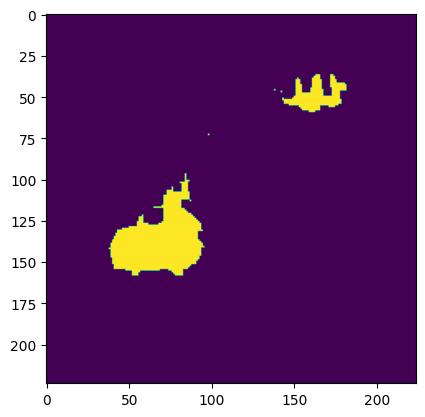

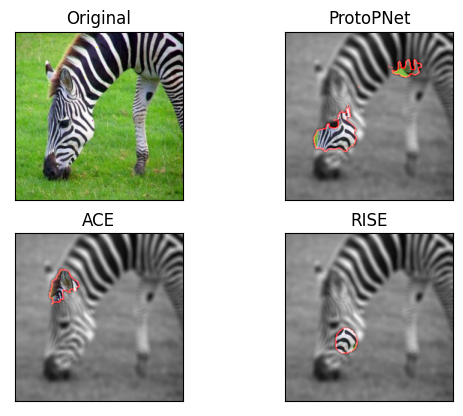

[[ 12  10  17  16  16  17  28  23  16  12  26  17  19  22  18  14  19  18
   19  19  30  29  38  35  28  21  20  12  15  28  23  27  18  18  28  22
   23  37  43  41  31  26  26  31  35  44  36  35  42  40  49  50  35  38
   19  14  14  13  14  20  17  17  16  18  24  23  30  25  26  45  47  44
   38  43  32  37  41  29  14  16  17  16  15  17  21  21  23  32  37  28
   18  13  19  23  25  18  12  12  12  16  16  14  12  11  14  21  22  21
   19  15  15  16  19  22  34  34  34  51  42  22  24  26  28  34  29  32
   23  20  26  34  52  40  32  35  36  31  27  33  23  19  27  35  33  35
   41  47  39  36  38  45  49  34  20  13  15  14  14  13  11  10  11  11
   11  11  12  11  13  13  11  12  14  16  17  18  25  26  24  17  18  21
   23  27  30  24  18  18  26  27  16  14  12  13  17  12  16  29  17  19
   14  16  13  31  24  21  29  20  23  38  25  11  13  13  12  12  11  11
   11  13  11   9   9  13   9   9]
 [ 13  10  17  23  24  30  31  27  16  17  27  17  20  23  23  19  18  19
   

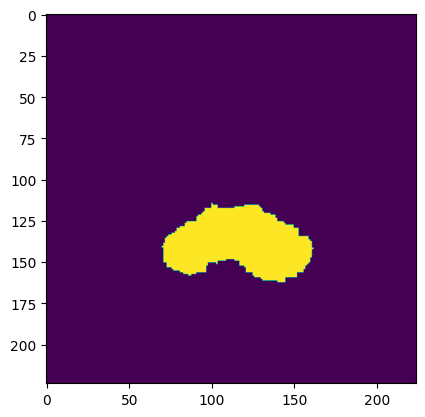

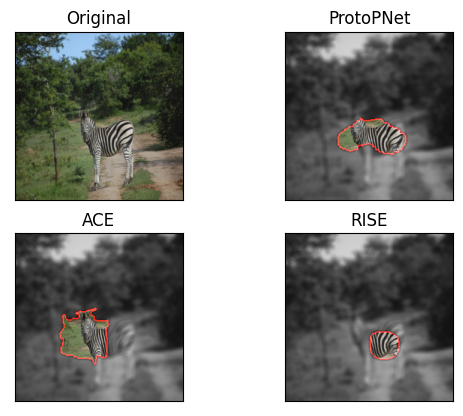

In [283]:
def load_image(path, color):
    img = cv2.imread(path, color )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_image_hsv(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return img
MASTER_PATH = 'ankieta/'
klasa = 'african_crocodile'
#take images from folder MASTER_PATH + klasa 

index = 1
for klasa in os.listdir(MASTER_PATH):

   
    con_img = []
    for i, path in enumerate(glob.glob(MASTER_PATH + klasa +"/*")):
        
        img_main_pathes = glob.glob(path +"/*.png")
        if len(img_main_pathes) > 0:
            img_main = load_image(img_main_pathes[0], cv2.IMREAD_COLOR)
            con_img.append(img_main)
            #append white 30 px margin to last image added to con_img
            con_img.append(np.ones((np.shape(img_main)[0], 30, 3), dtype=np.uint8)*255)

            ace_img = load_image(glob.glob(path + "/ACE/" + "/*.png")[0], cv2.IMREAD_COLOR)
            protop_img = load_image_hsv(glob.glob(path + "/ProtoPnet/" + "/*.png")[0])
            rais_img = load_image(glob.glob(path + "/RISE/" + "/*.jpg")[0], cv2.IMREAD_COLOR)

            ace_out = ace_flow(ace_img, img_main)
            protop_out = protop_flow(protop_img, img_main)
            rais_out = rais_flow(rais_img, img_main)

            #img to hsv
            protop_img_hsv = cv2.cvtColor(ace_out, cv2.COLOR_RGB2BGR)
            #save images
            # cv2.imwrite(MASTER_PATH +str(i)+str(klasa)+"ACE.jpg", cv2.cvtColor(ace_out, cv2.COLOR_RGB2BGR))
            # cv2.imwrite(MASTER_PATH +str(i)+str(klasa)+"ProtoPnet.png", cv2.cvtColor(protop_out , cv2.COLOR_RGB2BGR))
            # cv2.imwrite(MASTER_PATH +str(i)+str(klasa)+"RISE.png", cv2.cvtColor(rais_out , cv2.COLOR_RGB2BGR))

            # cv2.imwrite('output/ACE'+str(i)+str(klasa)+".jpg", cv2.cvtColor(ace_out, cv2.COLOR_RGB2BGR))
            # cv2.imwrite('output/ProtoPnet' +str(i)+str(klasa)+".png", cv2.cvtColor(protop_out , cv2.COLOR_RGB2BGR))
            # cv2.imwrite('output/RISE' +str(i)+str(klasa)+".png", cv2.cvtColor(rais_out , cv2.COLOR_RGB2BGR))


            compare = save_compare(img_main, protop_out, ace_out, rais_out, klasa, i)
        
            #concatenate img from con_img list and save to file
    if con_img != []:     
        #concatenate with margin 30px

        con_img = np.concatenate(con_img[:-1], axis=1)
        cv2.imwrite('output/'+str(klasa)+".png", cv2.cvtColor(con_img , cv2.COLOR_RGB2BGR))

# rais_img = load_image('RAIS/'+ klasa+'.jpg', cv2.IMREAD_GRAYSCALE)
        

